In [194]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools
from tqdm import tqdm
%matplotlib inline

In [2]:
# https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [121]:
SOYBEANS = 'Soybeans(CBOT)'
CORN = 'Corn(CBOT)'

In [97]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [102]:
mrci_eod_filter = os.path.join('data', '*.csv')
mrci_eod_files = glob.glob(mrci_eod_filter)

In [105]:
converters = {'month': lambda d: pd.to_datetime(d.replace('\r\n', ''), format='%b%y'),
              'date': lambda d: pd.to_datetime(d, format='%y%m%d'),
              'close': lambda c: np.double(c.replace('~','.'))
           }

In [112]:
col_names = ['future_name', 'month', 'date', 'close']
futures_all = pd.concat((pd.read_csv(f, 
                                     usecols=[1, 2, 3, 7],
                                     header=1,
                                     names=col_names,
                                     converters=converters,
                                    )
                                    for f in mrci_eod_files),
                       ignore_index=True).drop_duplicates()

In [116]:
futures_all.to_pickle('clean_data/all_close.pkl')

In [117]:
def get_front_month(contract_name, data):
    front_month = data.loc[data.future_name == contract_name]
    front_month = front_month.loc[front_month.groupby('date')['month'].idxmin()]
    front_month.sort_values(by='date', inplace=True)
    front_month.set_index('date', inplace=True)
    front_month = front_month.asfreq('B').fillna(method='ffill')
    return front_month

In [141]:
def get_monthly_average(close):
    average =  close.resample('m').mean()
    return average

In [135]:
def seasonal_charts(close, freq):
    decomposition = seasonal_decompose(close, freq=freq)
    fig = plt.figure()
    fig = decomposition.plot();
    fig.set_size_inches(15, 8)
    return decomposition

In [207]:
def find_optimal_pdq(data, train_delta, start_train=None):
    train_date = data.index.max() - train_delta
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    test_results = []
    
    for param in tqdm(pdq):
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data.loc[start_train:train_date],
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                result_string = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
                test_results.append([result_string, results.aic])

            except Exception as e:
                print('exception in:', pdq, seasonal_pdq)
                print(e)
                continue
    results_df = pd.DataFrame(test_results, columns=['key', 'aic'])
    print(results_df.loc[results_df.aic.idxmin()])
    return results_df

In [148]:
def plot_act_pacf(close, freq, lags=24):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    #plot the ACF
    fig = sm.graphics.tsa.plot_acf(close.diff(freq).dropna(), lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    #plot the PACF
    fig = sm.graphics.tsa.plot_pacf(close.diff(freq).dropna(), lags=lags, ax=ax2)

In [216]:
def sarimax_plot(data, order, trend, seasonal_order, train_delta, predict_delta, start_date=None):
    train_date = data.index.max() - train_delta
    mod = sm.tsa.statespace.SARIMAX(
        data.loc[start_date:train_date],
        trend=trend,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False,
        seasonal_order=seasonal_order,
    )
    res = mod.fit()
    print(res.summary())
    
    prediction = res.predict(res.nobs-train_delta, res.nobs+predict_delta)
    data.loc[start_date:].plot(figsize=(15, 10))
    prediction.plot(figsize=(15, 10))
    
    return res

In [203]:
pdq_results = find_optimal_pdq(corn.close, 12)

  0%|          | 0/8 [00:00<?, ?it/s]/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
 50%|█████     | 4/8 [01:07<01:01, 15.35s/it]/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Convergenc

key    ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:35679.037...
aic                                                35679
Name: 27, dtype: object


In [142]:
corn = get_front_month(CORN, futures_all)

In [143]:
corn_monthly = get_monthly_average(corn.close)

In [220]:
corn_monthly.to_pickle('clean_data/corn_monthly.pkl')

<Figure size 432x288 with 0 Axes>

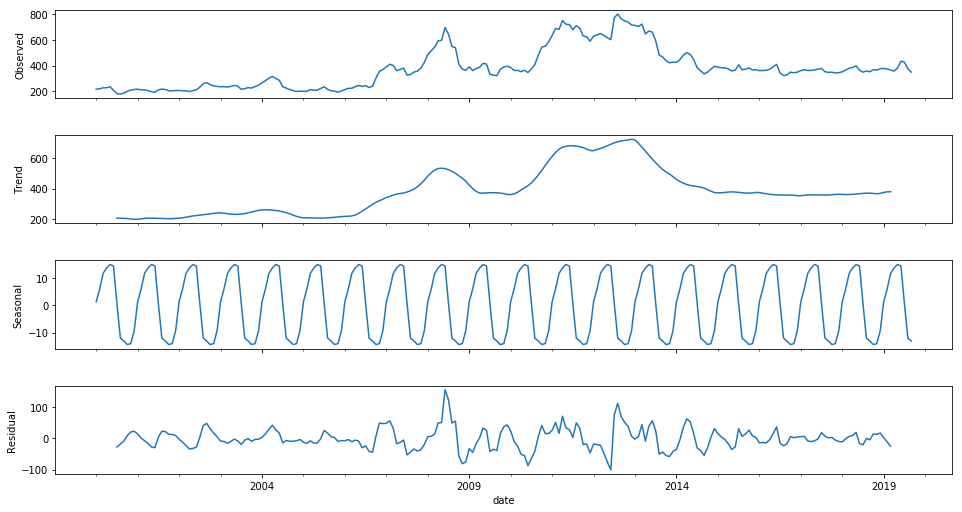

In [153]:
seasonal_charts(corn_monthly, 12);

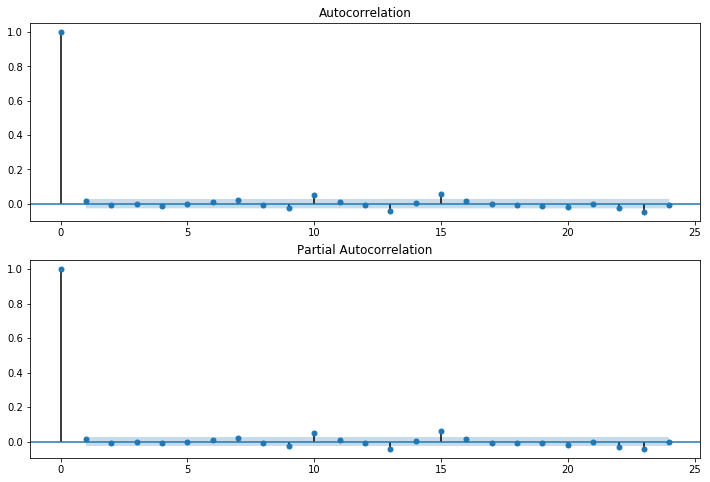

In [183]:
plot_act_pacf(corn.close, 1)

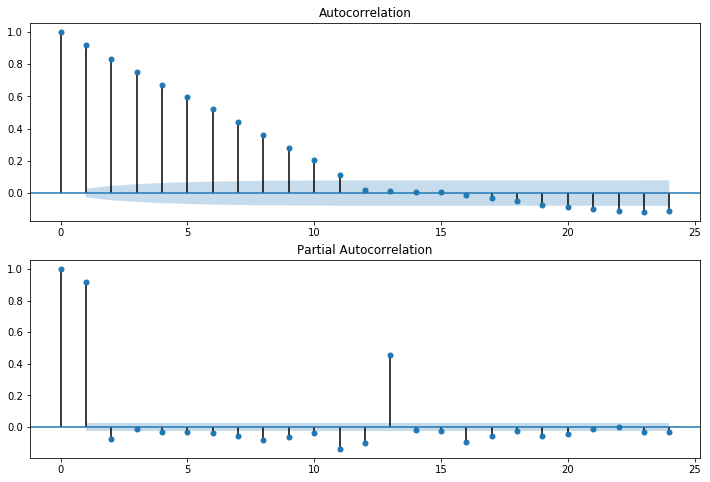

In [149]:
plot_act_pacf(corn.close, 12)

In [211]:
pdq_results = find_optimal_pdq(corn_monthly, 12, '2014-1-1')


  0%|          | 0/8 [00:00<?, ?it/s]/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 12%|█▎        | 1/8 [00:01<00:07

key    ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:273.41862...
aic                                              273.419
Name: 62, dtype: object


                                 Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                   57
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -132.709
Date:                            Mon, 09 Sep 2019   AIC                            273.419
Time:                                    20:25:05   BIC                            279.155
Sample:                                01-31-2014   HQIC                           275.288
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3120      0.471      0.663      0.507      -0.610       1.234
ma.L1         -0.7537      0.381   

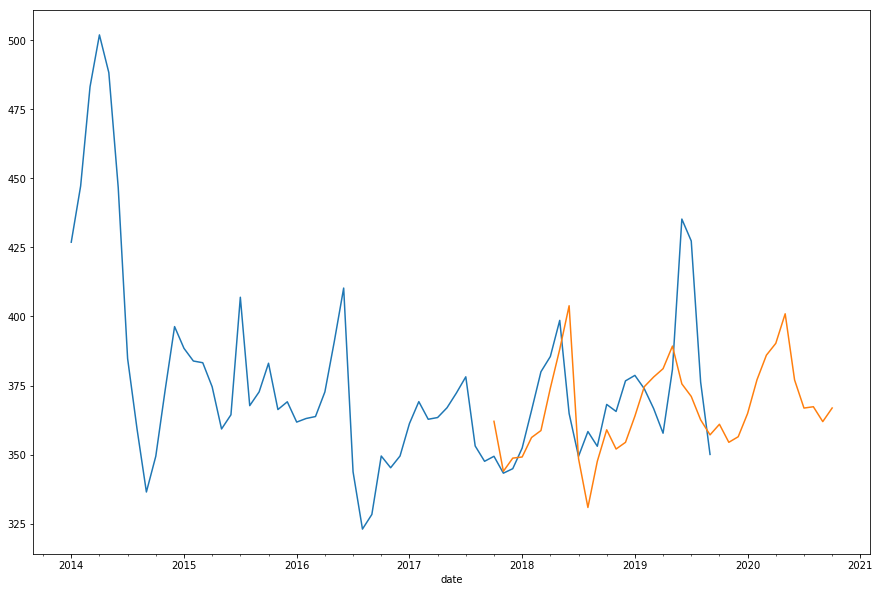

In [217]:
res = sarimax_plot(corn_monthly, 
                   order=(1, 1, 1), 
                   trend='n', 
                   seasonal_order=(1, 1, 0, 12), 
                   train_delta=12, 
                   predict_delta=24,
                   start_date='2014-1-1',
                  )

In [218]:
pdq_results = find_optimal_pdq(corn_monthly, 12)


  0%|          | 0/8 [00:00<?, ?it/s]/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]

 50%|█████     | 4/8 [00:06<00:05,  1.42s/it]/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 62%|██████▎   | 5/8 [00:08<00:04,  1.55s/it]/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

key    ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1946.7773...
aic                                              1946.78
Name: 27, dtype: object


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


                                 Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                  225
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -970.389
Date:                            Mon, 09 Sep 2019   AIC                           1946.777
Time:                                    20:26:57   BIC                           1956.642
Sample:                                01-31-2000   HQIC                          1950.770
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1995      0.064      3.113      0.002       0.074       0.325
ma.S.L12      -1.0000      0.045   

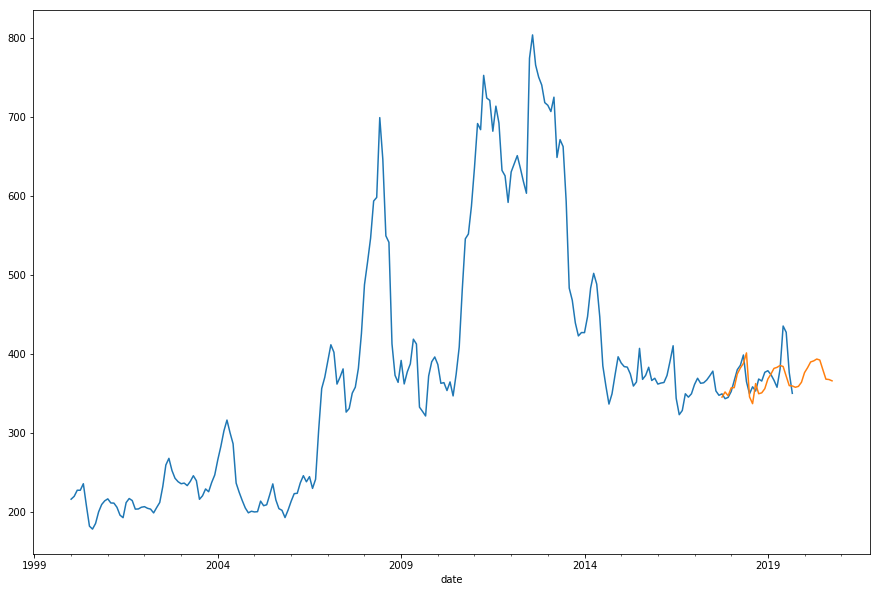

In [219]:
res = sarimax_plot(corn_monthly, 
                   order=(0, 1, 1), 
                   trend='n', 
                   seasonal_order=(0, 1, 1, 12), 
                   train_delta=12, 
                   predict_delta=24,
                   #start_date='2014-1-1',
                  )

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                  Statespace Model Results                                  
Dep. Variable:                                close   No. Observations:                  225
Model:             SARIMAX(10, 1, 10)x(1, 1, 1, 12)   Log Likelihood                -929.720
Date:                              Mon, 09 Sep 2019   AIC                           1905.439
Time:                                      20:06:52   BIC                           1979.999
Sample:                                  01-31-2000   HQIC                          1935.645
                                       - 09-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9443      1.545      0.611      0.541      -2.084       3.973
ar.L2          0.15

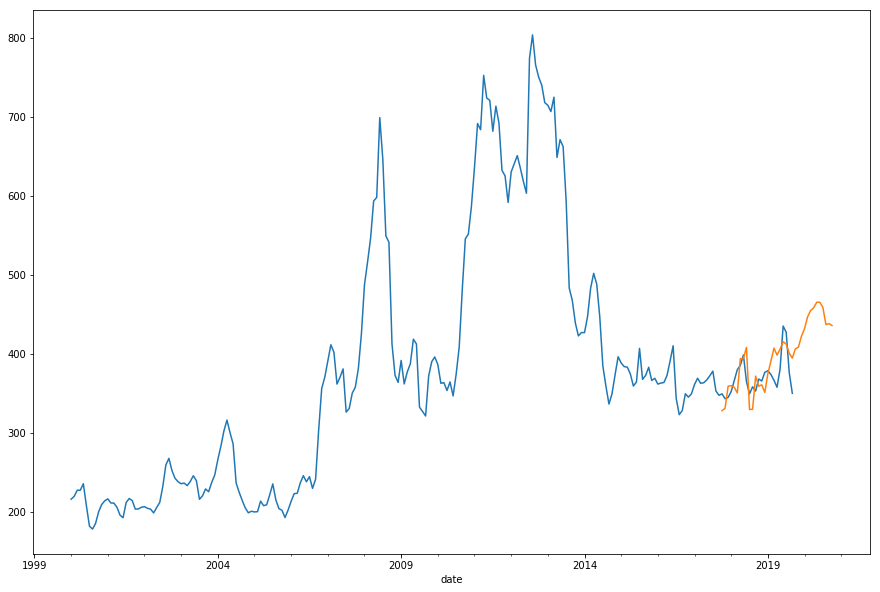

In [199]:
res = sarimax_plot(corn_monthly, 
                   order=(10, 1, 10), 
                   trend='n', 
                   seasonal_order=(1, 1, 1, 12), 
                   train_delta=12, 
                   predict_delta=24,
                   #start_date='2014-1-1',
                  )

In [ ]:
mod = sm.tsa.statespace.SARIMAX(
    soybeans_monthly_average.loc[:'2018-9-1'],
    trend='t',
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False,
    seasonal_order=(5, 1, 1, 12),
)
res = mod.fit()
res.summary()

In [12]:
soybeans = futures_all.loc[futures_all.future_name == SOYBEANS]

In [14]:
soybeans_front_month = soybeans.loc[soybeans.groupby('date')['month'].idxmin()]

In [15]:
soybeans_front_month.sort_values(by='date', inplace=True)

In [16]:
soybeans_front_month.set_index('date', inplace=True)

In [40]:
soybeans_front_month = soybeans_front_month.asfreq('B').fillna(method='ffill')

In [41]:
soybeans_front_month.tail()

,future_name,month,open,high,low,close,month_diff,close_diff
date,,,,,,,,
2019-08-30,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.5
2019-09-02,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.0
2019-09-03,Soybeans(CBOT),2019-11-01,866.25,869.25,859.25,868.5,0.0,-0.5
2019-09-04,Soybeans(CBOT),2019-11-01,867.25,879.50,864.25,875.5,0.0,7.0
2019-09-05,Soybeans(CBOT),2019-11-01,875.25,878.75,858.25,861.5,0.0,-14.0


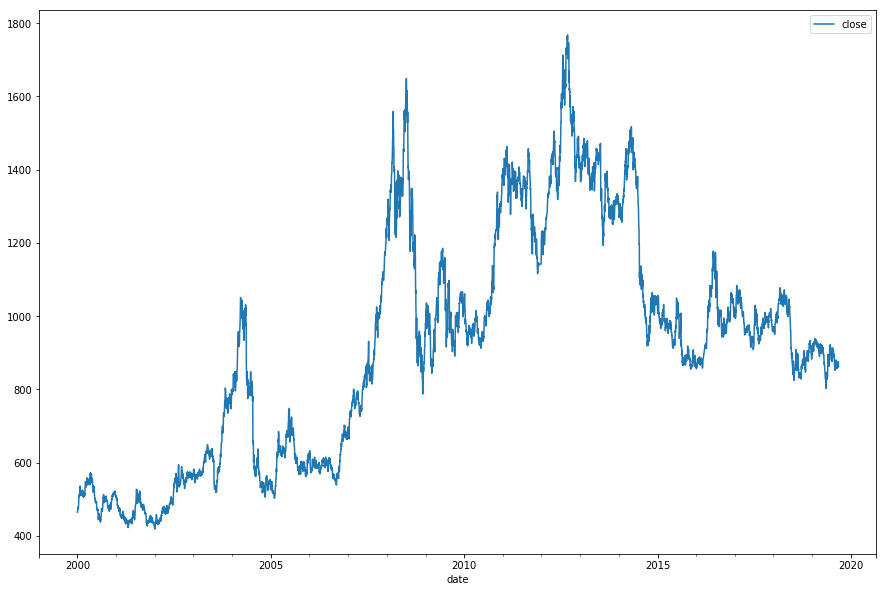

In [26]:
soybeans_front_month.plot.line(y='close', 
                               figsize=(15, 10), 
                               #xlim=('2014-09-05', '2019-09-05'),
                              );

In [42]:
soybeans_front_month['month_diff'] = soybeans_front_month.month.diff(1).dt.days

In [43]:
soybeans_front_month['close_diff'] =  soybeans_front_month.close.diff(1)

In [29]:
# Remove contract roll dates.
#soybeans_front_month = soybeans_front_month.loc[soybeans_front_month.month_diff == 0]

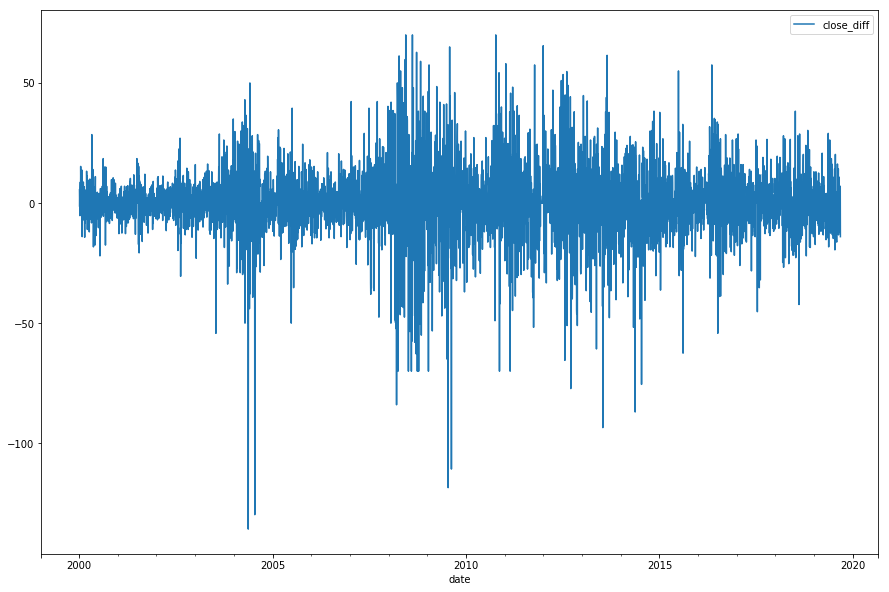

In [44]:
soybeans_front_month.plot.line(y='close_diff', figsize=(15, 10));

<Figure size 432x288 with 0 Axes>

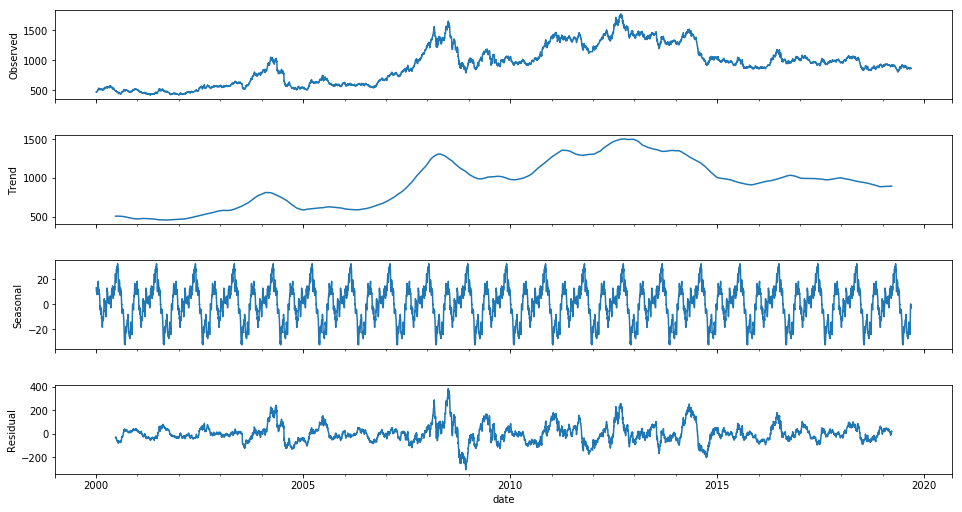

In [45]:
decomposition = seasonal_decompose(soybeans_front_month.close, freq=245)
fig = plt.figure()
fig = decomposition.plot();
fig.set_size_inches(15, 8)

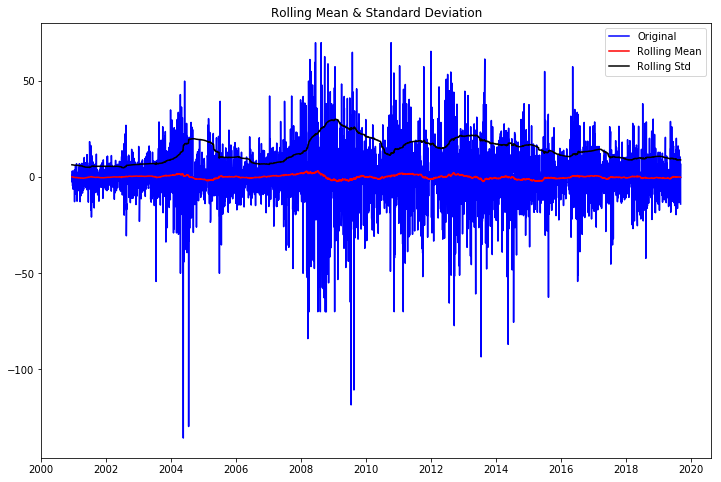

Results of Dickey-Fuller Test:
Test Statistic                  -20.250640
p-value                           0.000000
#Lags Used                       10.000000
Number of Observations Used    5121.000000
Critical Value (1%)              -3.431628
Critical Value (5%)              -2.862105
Critical Value (10%)             -2.567071
dtype: float64


In [49]:
test_stationarity(soybeans_front_month.close_diff[1:], 245)

(0, 0.2)

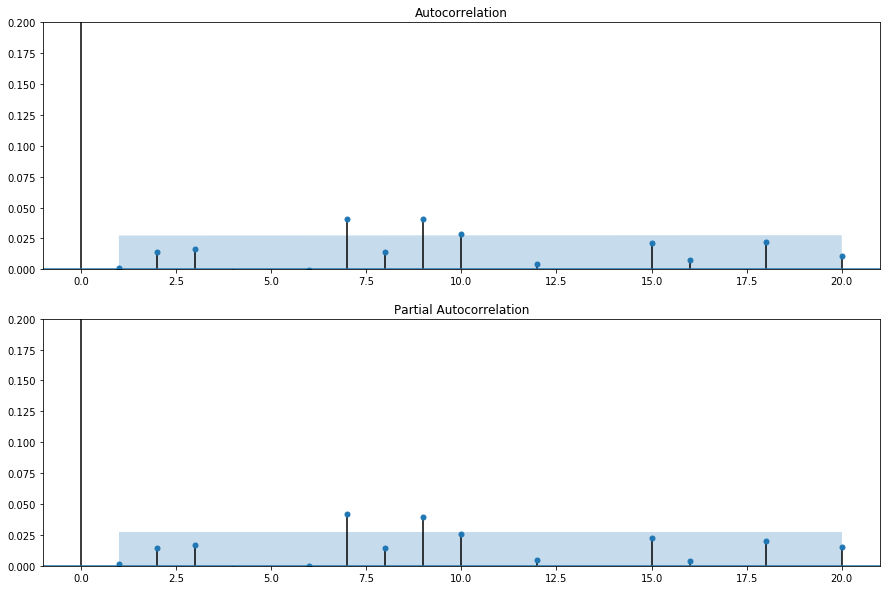

In [50]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(soybeans_front_month.close_diff.dropna(), lags=20, ax=ax1)
plt.ylim(0, 0.2)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(soybeans_front_month.close_diff.dropna(), lags=20, ax=ax2)
plt.ylim(0, 0.2)

In [115]:
soybeans_front_month['seasonal_diff'] = soybeans_front_month.close.diff(260)

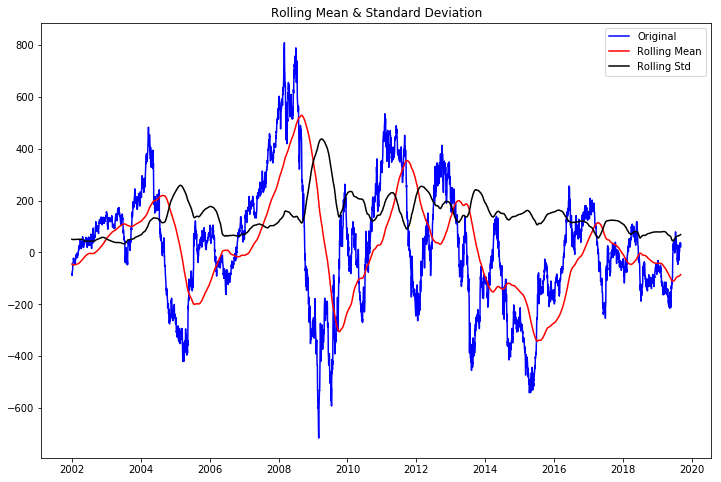

Results of Dickey-Fuller Test:
Test Statistic                   -3.568851
p-value                           0.006385
#Lags Used                       18.000000
Number of Observations Used    4854.000000
Critical Value (1%)              -3.431698
Critical Value (5%)              -2.862136
Critical Value (10%)             -2.567087
dtype: float64


In [118]:
test_stationarity(soybeans_front_month.seasonal_diff.dropna(), 260)

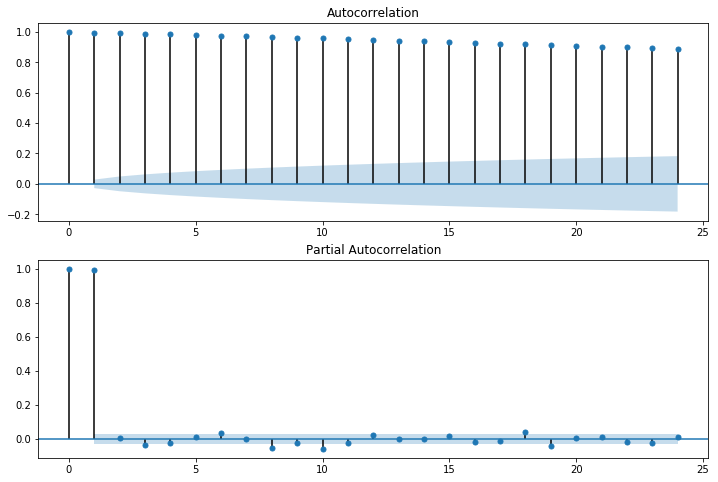

In [116]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(soybeans_front_month.seasonal_diff.dropna(), lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(soybeans_front_month.seasonal_diff.dropna(), lags=24, ax=ax2)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(
    soybeans_front_month.loc[:'2018-1-1'].close,
    trend='n',
    order=(7,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False,
    #seasonal_order=(0,1,1,260),
    seasonal_order=(7,1,7,52),
    freq='B',
)
res = mod.fit()
res.summary()

In [149]:
prediction = res.predict(start=4495, end=4694, dynamic=False)
prediction.head()

date
2017-03-28    978.891517
2017-03-29    982.282271
2017-03-30    978.287141
2017-03-31    971.702307
2017-04-03    957.105353
Freq: B, dtype: float64

In [150]:
soybeans_front_month['forecast'] = prediction

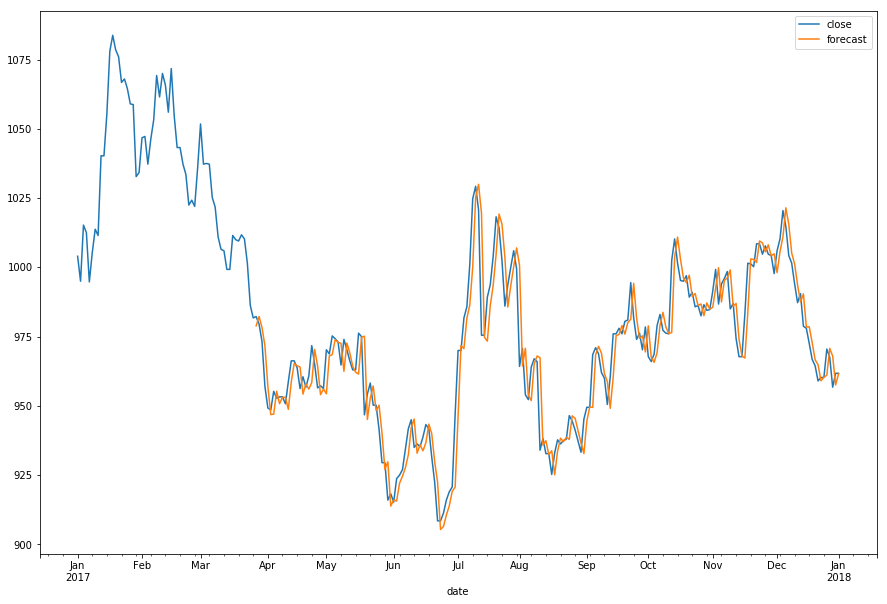

In [151]:
#plt.plot(soybeans_front_month.close, figsize=(15, 10))
#plt.plot(prediction, figsize=(15, 10))
soybeans_front_month.loc['2017-1-1': '2018-1-1', ['close', 'forecast']].plot(figsize=(15, 10))

In [152]:
soybeans_front_month.shape

(5133, 10)

In [153]:
soybeans_front_month['forecast'] = res.predict(start=4694, end=5132, dynamic=True) # all
#soybeans_front_month['forecast'] = res.predict(start=783, end=900, dynamic=True) 

In [154]:
soybeans_front_month.tail()

,future_name,month,open,high,low,close,month_diff,close_diff,forecast,seasonal_diff
date,,,,,,,,,,
2019-08-30,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.5,665.693062,25.50
2019-09-02,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.0,665.000594,25.50
2019-09-03,Soybeans(CBOT),2019-11-01,866.25,869.25,859.25,868.5,0.0,-0.5,664.308126,24.25
2019-09-04,Soybeans(CBOT),2019-11-01,867.25,879.50,864.25,875.5,0.0,7.0,663.615659,37.50
2019-09-05,Soybeans(CBOT),2019-11-01,875.25,878.75,858.25,861.5,0.0,-14.0,662.923191,22.25


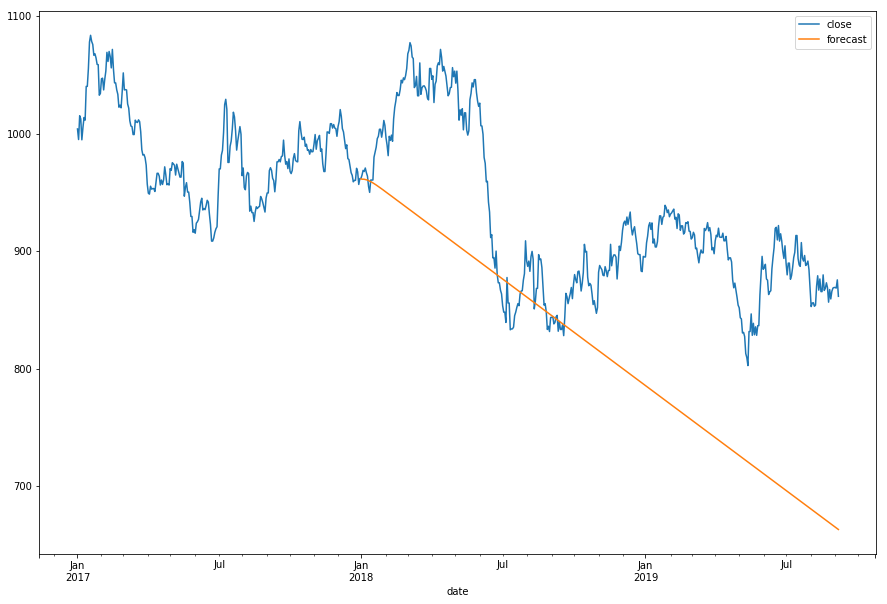

In [155]:
soybeans_front_month.dropna(subset=['close']).loc['2017-1-1':, ['close', 'forecast']].plot(figsize=(15, 10))

In [162]:
soybeans_front_month.tail()

,future_name,month,open,high,low,close,month_diff,close_diff,forecast,seasonal_diff
date,,,,,,,,,,
2019-08-30,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.5,665.693062,25.50
2019-09-02,Soybeans(CBOT),2019-11-01,868.50,877.75,867.00,869.0,0.0,0.0,665.000594,25.50
2019-09-03,Soybeans(CBOT),2019-11-01,866.25,869.25,859.25,868.5,0.0,-0.5,664.308126,24.25
2019-09-04,Soybeans(CBOT),2019-11-01,867.25,879.50,864.25,875.5,0.0,7.0,663.615659,37.50
2019-09-05,Soybeans(CBOT),2019-11-01,875.25,878.75,858.25,861.5,0.0,-14.0,662.923191,22.25


In [163]:
#soybeans_front_month.to_pickle('./clean_data/soybeans_front_month.pkl')

In [165]:
pwd

'/Users/flatironschool/Documents/personal_projects/mrci_data'

In [7]:
soybeans_front_month = pd.read_pickle('clean_data/soybeans_front_month.pkl')

In [8]:
#soybeans_front_month['monthly_average'] 
soybeans_monthly_average =  soybeans_front_month.close.resample('m').mean()

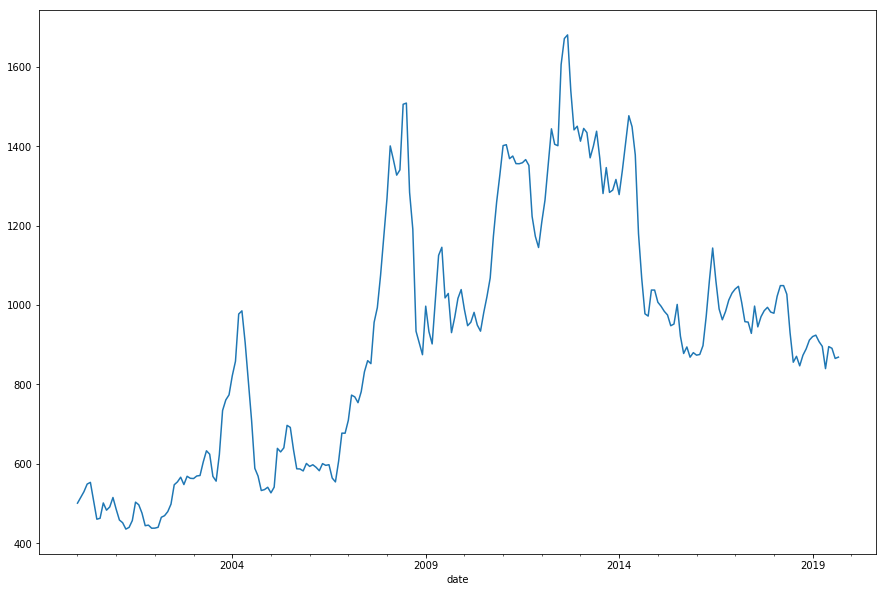

In [9]:
soybeans_monthly_average.plot(figsize=(15, 10))

<Figure size 432x288 with 0 Axes>

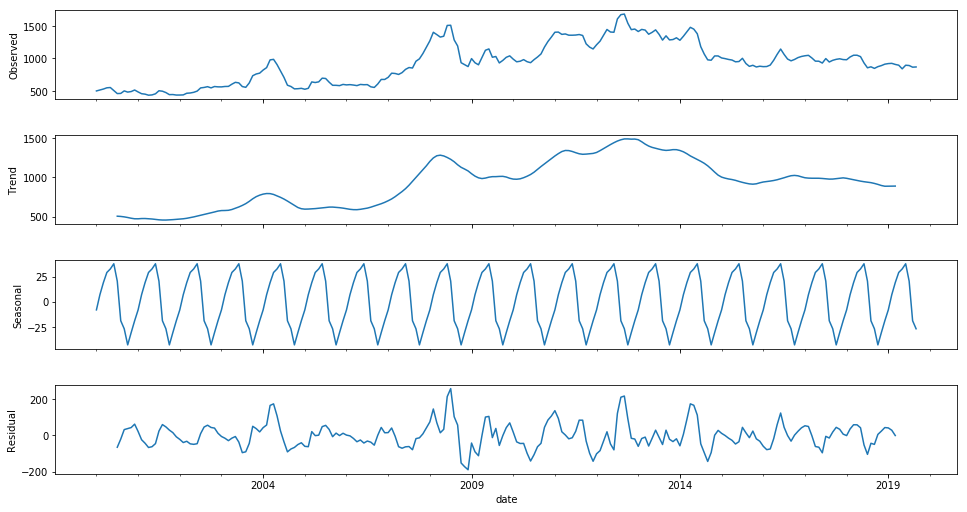

In [10]:
decomposition = seasonal_decompose(soybeans_monthly_average, freq=12)
fig = plt.figure()
fig = decomposition.plot();
fig.set_size_inches(15, 8)

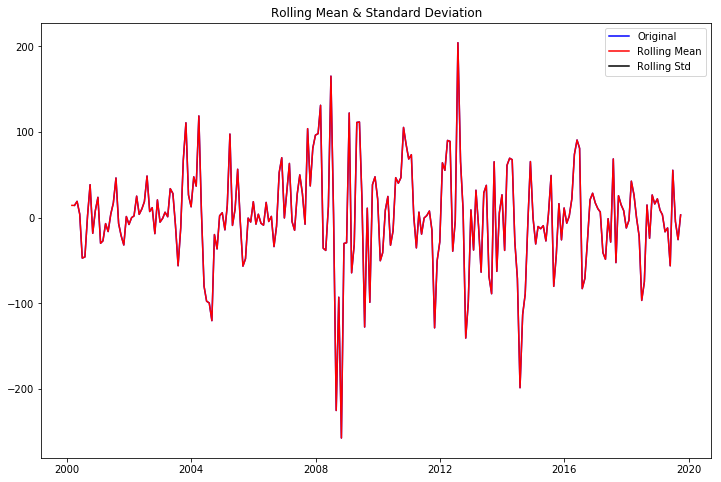

Results of Dickey-Fuller Test:
Test Statistic                -6.814090e+00
p-value                        2.080439e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


In [11]:
test_stationarity(soybeans_monthly_average.diff(1).dropna(), 1)

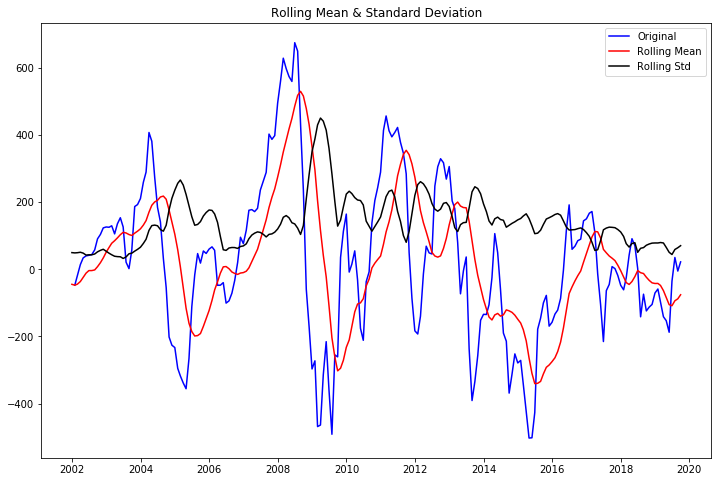

Results of Dickey-Fuller Test:
Test Statistic                  -3.038917
p-value                          0.031416
#Lags Used                      14.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


In [12]:
test_stationarity(soybeans_monthly_average.diff(12).dropna(), 12)

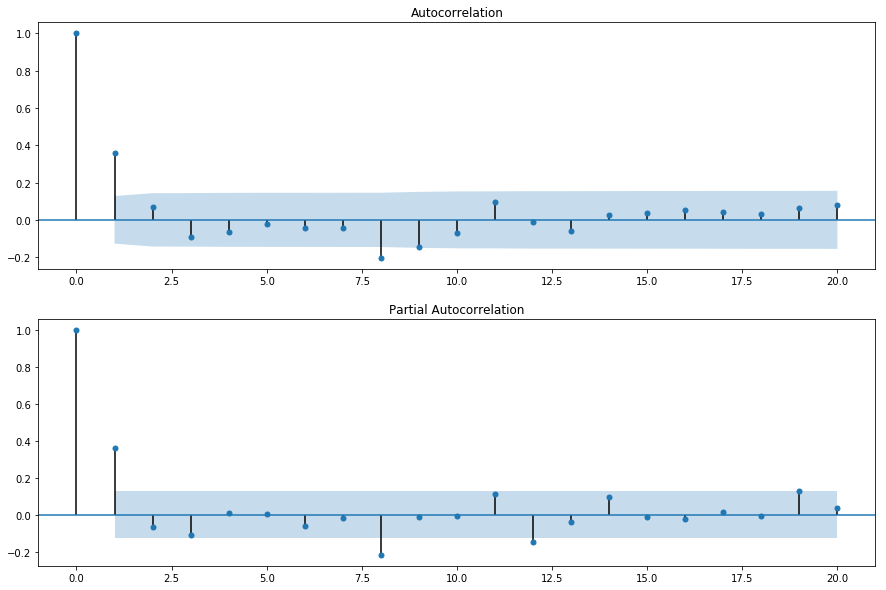

In [13]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(soybeans_monthly_average.diff(1).dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(soybeans_monthly_average.diff(1).dropna(), lags=20, ax=ax2)

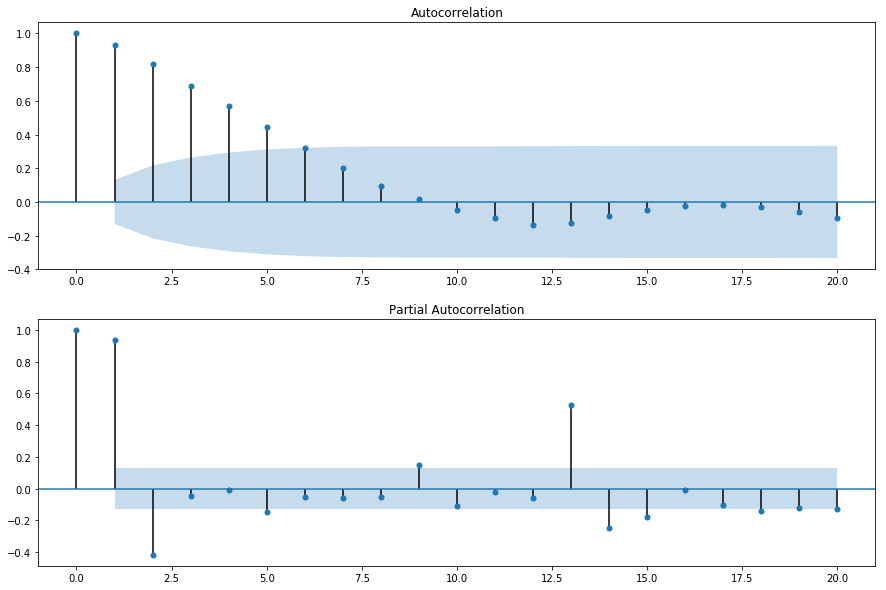

In [14]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(soybeans_monthly_average.diff(12).dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(soybeans_monthly_average.diff(12).dropna(), lags=20, ax=ax2)

In [ ]:
test_results = []
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(soybeans_monthly_average.loc[:'2018-9-1'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            result_string = 'ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
            test_results.append([result_string, results.aic])
            
        except Exception as e:
            print('exception in:', pdq, seasonal_pdq)
            print(e)
            continue

In [16]:
results_df = pd.DataFrame(test_results, columns=['key', 'aic'])

NameError: name 'test_results' is not defined

In [ ]:
results_df = pd.DataFrame(test_results, columns=['key', 'aic'])
results_df.loc[results_df.aic.idxmin()]

In [82]:
mod = sm.tsa.statespace.SARIMAX(
    soybeans_monthly_average.loc[:'2018-9-1'],
    trend='t',
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False,
    seasonal_order=(5, 1, 1, 12),
    freq='M',
)
res = mod.fit()
res.summary()

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                  224
Model:             SARIMAX(1, 0, 1)x(5, 1, 1, 12)   Log Likelihood                -840.089
Date:                            Mon, 09 Sep 2019   AIC                           1700.177
Time:                                    17:51:48   BIC                           1730.350
Sample:                                01-31-2000   HQIC                          1712.435
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0072      0.017     -0.434      0.664      -0.040       0.025
ar.L1          0.9886      0.017     58.197      0.000       0.955       1.022
ma.L1          0.3248      0.087      3.727      0.000       0.154       0.496
ar.S.L12      -0.1812      0.094     -1.920      0.055      -0.366       0.004
ar.S.L24      -0.2832      0.088     -3.236      0.001      -0.455      -0.112
ar.S.L36      -0.1706      0.101     -1.682      0.093      -0.369       0.028
ar.S.L48      -0.1466      0.082     -1.783      0.075      -0.308       0.015
ar.S.L60      -0.0344      0.080     -0.429      0.668      -0.191       0.123
ma.S.L12      -1.0000      0.092    -10.905      0.000      -1.180      -0.820
sigma2      3383.5640   2.71e-05   1.25e+08      0.000    3383.564    3383.564
===================================================================================
Ljung-Box (Q):                       41.50   Jarque-Bera (JB):                19.54
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+23. Standard errors may be unstable.
"""

In [83]:
prediction = res.predict(200, 223+24)

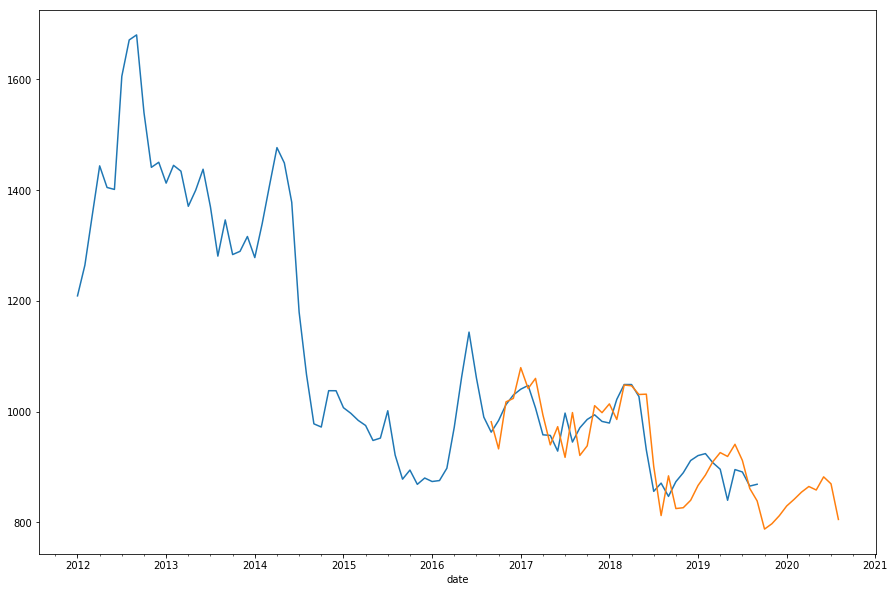

In [84]:
soybeans_monthly_average.loc['2012-1-1':].plot(figsize=(15, 10))
prediction.plot(figsize=(15, 10))

In [77]:
res.conf_int()

,0,1
drift,-0.039960,0.025471
ar.L1,0.955312,1.021900
ma.L1,0.153989,0.495595
ar.S.L12,-0.366195,0.003801
ar.S.L24,-0.454697,-0.111634
ar.S.L36,-0.369419,0.028197
ar.S.L48,-0.307689,0.014560
ar.S.L60,-0.191334,0.122583
ma.S.L12,-1.179743,-0.820265
sigma2,3383.563927,3383.564034


In [161]:
res.nobs

224